# Predicting Hotel Reservation Cancellations
## Norman Jen, Yamuna Umapathy

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

## Business Understanding

Our hotel chain, Flatiron Hotels, has been running into issues with cancellations.  

When a guest makes a reservation, the hotel understands that they must set aside a room for the reserved period.  If the guest cancels and Flatiron Hotels are not able to find another guest to fill the room, the room sits empty and Flatiron loses out on potential income.  It is critical to Flatiron's business model to have as many rooms occupied and paid for each night to provide the staffing and experience it strives to provide.

However, if they do not set aside a room in anticipation of a cancellation, Flatiron Hotels runs the risk of an upset guest, who arrives for a reservation and no room is ready for them!  This results in compensation from the company, damage to the brand name, and potential loss of future income from a repeat customer.  In the hotel and hospitality industries, repeat customers are extremely important to the business' consistent success.

To address this issue, we are creating a model that will predict which guests are likely to cancel by analyzing data on previous reservations.  Our goal is to provide Flatiron with an opportunity to reserve rooms to scale with the number of expected cancellations, so additional guests can make up for canceled rooms and occupancy can be maximized to the best of our ability each night.

## Data Analysis

Our data set comes from 2 hotels in Portugal, which provided very complete data on approximately 36,000 previous reservations throughout 2017 and 2018.  There was no data missing whatsoever and there were little to no misspellings, erroneous values, or non-sensical data points for us to deal with.

The data set provided information on:

1.  Number of adults and children booking the room
2.  The number of week nights and weekend nights booked for the stay
3.  The type of meal plan purchased by the guest
4.  Whether or not a parking space was required
5.  The type of room reserved
6.  Lead time, or how many days ahead of the reservation the booking was done
7.  The day, month, and year of the reservation
8.  How the reservation was made - Online, Offline, Corporate, Complementary, or through an Aviation company
9.  Whether or not the guest had made previous reservations at the same hotel and whether or not they had canceled those prior reservations
10.  The average price the reserved room goes for online
11.  The number of special requests made by the guest
12.  Whether or not the reservation was ultimately canceled or not

In [60]:
df = pd.read_csv('./Data/Hotel_Reservations.csv')

In [61]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [63]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


## EDA and Data Cleaning

Although we received a lot of useful information to use for our model, we wanted to add a few additional features.  In particular:

1.  The day, month, and year that the booking was actually made
2.  The total guest count
3.  The total length of stay

First, we combined the arrival day, month, and year into a datetime object.  We were then able to subtract the lead time (in days) from that datetime object to get the datetime of booking.  We then needed to parse that back out into individual features for day, month, and year to maintain a numeric dataframe that can be processed by Scikit-Learn.

The total guest count and length of stay were simple additive functions of number of adults + number of children, and number of week nights + number of weekend nights, respectively.

Overall, our dataset was very clean and required no imputation.  However, we discovered that there were 37 records with arrival dates of 2/29/2018.  Since 2018 was not a leap year, this date does not exist.  We did not want to imbalance the 2/28/2018 or 3/1/2018 dates and since we did not have information on what these dates were meant to represent and we had a very healthy amount of data, we felt comfortable eliminating those results.

In [64]:
#Concatenated arrival date, month, and year to create a datetime
df['arrival_date'] = df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str)
df.loc[:, 'arrival_date'] = pd.to_datetime(df['arrival_date'], format='%Y-%m-%d', errors='coerce')
#Dropped incorrect dates (2/29)
df = df.dropna(subset=['arrival_date'])
#Used the lead time metric and arrival date to calculate booking date
df['timedelta'] = pd.to_timedelta(df['lead_time'], unit='D')
df['booking_date'] = df['arrival_date'] - df['timedelta']
df = df.drop(columns=['timedelta'])
#Parsed out booking date into day, month, and year
df['booking_year'] = df['booking_date'].dt.year
df['booking_month'] = df['booking_date'].dt.month
df['booking_day'] = df['booking_date'].dt.day
#Returned arrival day to integer
df['arrival_day'] = df['arrival_date'].dt.day
df.drop(columns=['arrival_date', 'booking_date'], axis = 1, inplace = True)
#Calculated total guest count
df['total_guests'] = df['no_of_adults'] + df['no_of_children']
#Calculated total length of stay
df['length_of_stay'] = df['no_of_weekend_nights'] + df['no_of_week_nights']

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36238 entries, 0 to 36274
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36238 non-null  object 
 1   no_of_adults                          36238 non-null  int64  
 2   no_of_children                        36238 non-null  int64  
 3   no_of_weekend_nights                  36238 non-null  int64  
 4   no_of_week_nights                     36238 non-null  int64  
 5   type_of_meal_plan                     36238 non-null  object 
 6   required_car_parking_space            36238 non-null  int64  
 7   room_type_reserved                    36238 non-null  object 
 8   lead_time                             36238 non-null  int64  
 9   arrival_year                          36238 non-null  int64  
 10  arrival_month                         36238 non-null  int64  
 11  market_segment_

In [66]:
#Re-ordered columns for clarity and for examining specific data points or groups if necessary
reordered = ['booking_status', 'total_guests', 'no_of_adults', 'no_of_children', 'length_of_stay', 'no_of_week_nights', 'no_of_weekend_nights', 'booking_year', 'booking_month', 'booking_day', 'arrival_year', 'arrival_month', 'arrival_day', 'lead_time', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'room_type_reserved', 'avg_price_per_room', 'type_of_meal_plan', 'required_car_parking_space', 'market_segment_type', 'no_of_special_requests']
df = df[reordered]
df

,booking_status,total_guests,no_of_adults,no_of_children,length_of_stay,no_of_week_nights,no_of_weekend_nights,booking_year,booking_month,booking_day,...,lead_time,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,room_type_reserved,avg_price_per_room,type_of_meal_plan,required_car_parking_space,market_segment_type,no_of_special_requests
0,Not_Canceled,2,2,0,3,2,1,2017,2,20,...,224,0,0,0,Room_Type 1,65.00,Meal Plan 1,0,Offline,0
1,Not_Canceled,2,2,0,5,3,2,2018,11,1,...,5,0,0,0,Room_Type 1,106.68,Not Selected,0,Online,1
2,Canceled,1,1,0,3,1,2,2018,2,27,...,1,0,0,0,Room_Type 1,60.00,Meal Plan 1,0,Online,0
3,Canceled,2,2,0,2,2,0,2017,10,21,...,211,0,0,0,Room_Type 1,100.00,Meal Plan 1,0,Online,0
4,Canceled,2,2,0,2,1,1,2018,2,22,...,48,0,0,0,Room_Type 1,94.50,Not Selected,0,Online,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,Not_Canceled,3,3,0,8,6,2,2018,5,10,...,85,0,0,0,Room_Type 4,167.80,Meal Plan 1,0,Online,1
36271,Canceled,2,2,0,4,3,1,2018,3,3,...,228,0,0,0,Room_Type 1,90.95,Meal Plan 1,0,Online,2
36272,Not_Canceled,2,2,0,8,6,2,2018,2,3,...,148,0,0,0,Room_Type 1,98.39,Meal Plan 1,0,Online,2
36273,Canceled,2,2,0,3,3,0,2018,2,17,...,63,0,0,0,Room_Type 1,94.50,Not Selected,0,Online,0


## Encoding

We manually changed a few features' categorical values to have numerical values.  2 of these features already had numerical values (Meal Plan and Room Type), the Booking Status feature was binary, and we wanted to combine the Market Segment feature's Corporate, Complementary, and Aviation values into an "Other" category.

In [67]:
#Manually encoded categorical variables to have numerical values
df.loc[:, 'type_of_meal_plan'] = df['type_of_meal_plan'].replace({'Not Selected': 0, 'Meal Plan 1': 1, 'Meal Plan 2': 2, 'Meal Plan 3': 3})
df.loc[:, 'room_type_reserved'] = df['room_type_reserved'].replace({'Room_Type 1': 1, 'Room_Type 2': 2, 'Room_Type 3': 3, 'Room_Type 4': 4, 'Room_Type 5': 5, 'Room_Type 6': 6, 'Room_Type 7': 7})
df.loc[:, 'market_segment_type'] = df['market_segment_type'].replace({'Online': 0, 'Offline': 1, 'Corporate': 2, 'Complementary': 2, 'Aviation': 2})
df.loc[:, 'booking_status'] = df['booking_status'].replace({'Not_Canceled': 0, 'Canceled': 1})

In [68]:
df.head()

,booking_status,total_guests,no_of_adults,no_of_children,length_of_stay,no_of_week_nights,no_of_weekend_nights,booking_year,booking_month,booking_day,...,lead_time,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,room_type_reserved,avg_price_per_room,type_of_meal_plan,required_car_parking_space,market_segment_type,no_of_special_requests
0,0,2,2,0,3,2,1,2017,2,20,...,224,0,0,0,1,65.00,1,0,1,0
1,0,2,2,0,5,3,2,2018,11,1,...,5,0,0,0,1,106.68,0,0,0,1
2,1,1,1,0,3,1,2,2018,2,27,...,1,0,0,0,1,60.00,1,0,0,0
3,1,2,2,0,2,2,0,2017,10,21,...,211,0,0,0,1,100.00,1,0,0,0
4,1,2,2,0,2,1,1,2018,2,22,...,48,0,0,0,1,94.50,0,0,0,0


## Correlation

Before applying the data to our models, we wanted to take a preliminary look at the correlation between the features in our data set and our target variable.

We see that some features have a high correlation such as lead time and number of special requests.  Others are less important but do have a small degree of correlation.

Given this information, we decided to split our data into 2 separate train-test splits - one with all features included, and one with only features with correlations of ~0.1 or higher.  We ran all models with both splits to see the effect of having more complete vs. more streamlined feature sets on the model's performance.

In [69]:
correlation = abs(df.corrwith(df['booking_status']))
correlation = correlation.sort_values(ascending = False)
correlation

booking_status                          1.000000
lead_time                               0.438629
no_of_special_requests                  0.253339
arrival_year                            0.179762
avg_price_per_room                      0.142721
market_segment_type                     0.136291
booking_month                           0.134092
repeated_guest                          0.107490
length_of_stay                          0.103474
no_of_week_nights                       0.092904
total_guests                            0.089598
no_of_adults                            0.086671
required_car_parking_space              0.086053
no_of_weekend_nights                    0.061704
no_of_previous_bookings_not_canceled    0.060046
type_of_meal_plan                       0.049641
booking_day                             0.047622
no_of_previous_cancellations            0.033871
no_of_children                          0.033033
room_type_reserved                      0.023313
arrival_month       

## Model Choice and Validation

We chose 3 different classifier models to use - Logistic Regression, Decision Trees, and Random Forest Classifier.  All 3 specialized in classification through different methods, each with distinct advantages and disadvantages, in particular regarding prediction, probability, and over-fitting.  We implemented all 3 to make sure we used the model with the high predictive power without over-fitting.

For a validation metric, we chose to primarily examine the AUC of a ROC graph.  We determined that neither False Positives nor False Negatives had more dire consequences than the other, as both caused problems but neither were catastrophic.

False Positive - In this case, our model would classify a reservation as being likely to be canceled in the future, when the guest never makes a cancellation.  When Flatiron Hotels flags a reservation as likely to cancel, it doesn't pro-actively cancel the reservation or ignore it.  Instead, it continues with booking as normal, knowing that several of the bookings made in the meantime will be cancelled and last-minute changes will occur.  However, we do run the potential risk of a guest arriving for a reservation when the hotel is already fully booked.  This will result in damage to the brand image, potential loss of a repeat customer, and likely compensation to make up for our error.  Although problematic, there are many ways to prevent the worst-case scenario without specifically blocking off a room for a reservation that is likely to cancel.

False Negative - In this case, our model would classify a reservation as likely to be maintained, but is ultimately canceled.  Although not ideal and hopefully minimized, it is understood that this will happen occasionally.  We may still be able to fill the room if the cancellation happens far enough in advance or if we offer a discounted rate but even if it remains empty, we still only suffer a loss of potential income and are not in a position where we are paying for compensation or losing out on future income.

We concluded that the false positive and false negative worst-case scenarios are approximately even in terms of consequences because, although the consequences of a false positive are greater, it would be rarer for the worst-case scenario to happen and would scale with the false negative's lighter consequences, but more inevitable worst-case scenario.

We decided on AUC as our main metric because we wanted overall performance on false positives and false negatives, with a slight bias towards the positive class since we have measures in place to prevent the consequences of a false positive.  Although the consequences of a false negative aren't as severe, we don't have as many counter-measures to prevent the financial loss to Flatiron Hotels.

Finally, we used cross-validation to evaluate all models' AUC score to make sure that our split wasn't an outlier and providing results that weren't representative of the population.

## Logistic Regression

Our first model was Logistic Regression.  Because our target variable is a binary classification, Logistic Regression was our first thought for a baseline model.

We first ran our data set using all features, with the exception of Booking ID, which is a unique classifier and will thus have no effect on our predictive model.  We encoded the categorical variables and scaled the numeric variables before concatenating back into X_train, X_test, y_train, and y_test.

Next, we created a mirrored train-test split with only features with higher correlation to our target variable.  The goal was to evaluate whether the additional features were causing noise or collinearity that may lead to overfitting.  These were encoded, scaled, and concatenated into X_train_hicorr and X_test_hicorr, with y_train and y_test remaining the same.

Our Logistic Regression model with all features had an AUC score of 0.8722, which was pretty good!  It also didn't seem to be over-fit, with train and test scores being close to one another.  The Logistic Regression model with feature selection scored slightly lower at 0.8553.

In [70]:
#Using all columns
X = df.drop(columns = 'booking_status', axis = 1)
y = df['booking_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 100)

#One-hot-encoded categorical features
ohe = OneHotEncoder(drop="first", sparse=False)
X_train_nominal = X_train[['booking_year', 'booking_month', 'booking_day', 'arrival_year', 'arrival_month', 'arrival_day', 'type_of_meal_plan', 'market_segment_type', 'required_car_parking_space', 'repeated_guest', 'room_type_reserved']]
X_test_nominal = X_test[['booking_year', 'booking_month', 'booking_day', 'arrival_year', 'arrival_month', 'arrival_day', 'type_of_meal_plan', 'market_segment_type', 'required_car_parking_space', 'repeated_guest', 'room_type_reserved']]
X_train_nominal_encoded = pd.DataFrame(ohe.fit_transform(X_train_nominal))
X_test_nominal_encoded = pd.DataFrame(ohe.transform(X_test_nominal))

#Scaled numerical features using StandardScaler
scaler = StandardScaler()
X_train_num = X_train[['total_guests', 'no_of_adults', 'no_of_children', 'length_of_stay', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'avg_price_per_room', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']]
X_test_num = X_test[['total_guests', 'no_of_adults', 'no_of_children', 'length_of_stay', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'avg_price_per_room', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']]
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num))
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num))

#Concatenated encoded categorical and scaled numerical dataframes back into a full dataframe of encoded/scaled independent variables
X_train = pd.concat([X_train_nominal_encoded, X_train_num_scaled], axis = 1)
X_test = pd.concat([X_test_nominal_encoded, X_test_num_scaled], axis = 1)

#Used a Logistic Regression model and calculated AUC, recall, precision, accuracy, and F1
logreg = LogisticRegression(fit_intercept = False, max_iter = 1000, C = 1e5, random_state = 100, solver = 'liblinear')
y_score_log = logreg.fit(X_train, np.ravel(y_train)).decision_function(X_test)
fpr_log, tpr_log, thresholds = roc_curve(y_test, y_score_log)
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

#Printed results
print("Logistic Regression Using All Features")
print(f"AUC: {cross_val_score(logreg, X_test, y_test, cv=5, scoring = 'roc_auc').mean():.4f}")
print(f"Train Recall: {recall_score(y_train, y_hat_train):.4f}")
print(f"Test Recall: {recall_score(y_test, y_hat_test):.4f}")
print(f"Train Precision: {precision_score(y_train, y_hat_train):.4f}")
print(f"Test Precision: {precision_score(y_test, y_hat_test):.4f}")
print(f"Train Accuracy: {accuracy_score(y_train, y_hat_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_hat_test):.4f}")
print(f"Train F1 Score: {f1_score(y_train, y_hat_train):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_hat_test):.4f}")

Logistic Regression Using All Features
AUC: 0.8722
Train Recall: 0.6474
Test Recall: 0.6213
Train Precision: 0.7478
Test Precision: 0.7551
Train Accuracy: 0.8137
Test Accuracy: 0.8078
Train F1 Score: 0.6940
Test F1 Score: 0.6817


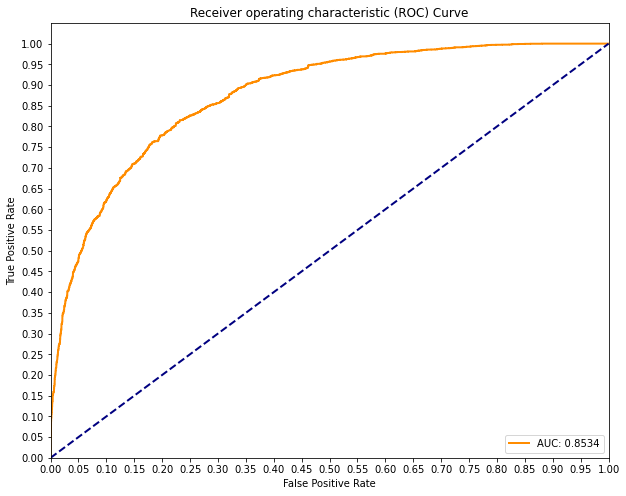

In [71]:
#Visualized ROC Curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr_log, tpr_log, color='darkorange',
         lw=lw, label=f"AUC: {cross_val_score(logreg, X, y, cv=5, scoring = 'roc_auc').mean():.4f}")
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [72]:
#Using only features with high correlation to target variable
X_hicorr = df.drop(columns = 'booking_status', axis = 1)
X_train_hicorr, X_test_hicorr, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 100)

#One-hot-encoded categorical features
ohe = OneHotEncoder(drop="first", sparse=False)
X_train_nominal_hicorr = X_train_hicorr[['market_segment_type', 'booking_month', 'repeated_guest']]
X_test_nominal_hicorr = X_test_hicorr[['market_segment_type', 'booking_month', 'repeated_guest']]
X_train_nominal_encoded_hicorr = pd.DataFrame(ohe.fit_transform(X_train_nominal_hicorr))
X_test_nominal_encoded_hicorr = pd.DataFrame(ohe.transform(X_test_nominal_hicorr))

#Scaled numerical features using StandardScaler
scaler = StandardScaler()
X_train_num_hicorr = X_train_hicorr[['lead_time', 'no_of_special_requests', 'avg_price_per_room', 'length_of_stay', 'total_guests']]
X_test_num_hicorr = X_test_hicorr[['lead_time', 'no_of_special_requests', 'avg_price_per_room', 'length_of_stay', 'total_guests']]
X_train_num_scaled_hicorr = pd.DataFrame(scaler.fit_transform(X_train_num_hicorr))
X_test_num_scaled_hicorr = pd.DataFrame(scaler.transform(X_test_num_hicorr))

#Concatenated encoded categorical and scaled numerical dataframes back into a full dataframe of encoded/scaled independent variables
X_train_hicorr = pd.concat([X_train_nominal_encoded_hicorr, X_train_num_scaled_hicorr], axis = 1)
X_test_hicorr = pd.concat([X_test_nominal_encoded_hicorr, X_test_num_scaled_hicorr], axis = 1)

#Used a Logistic Regression model and calculated AUC, recall, precision, accuracy, and F1
logreg_hicorr = LogisticRegression(fit_intercept = False, max_iter = 1000, C = 1e5, random_state = 100)
y_score_log_hicorr = logreg_hicorr.fit(X_train_hicorr, np.ravel(y_train)).decision_function(X_test_hicorr)
fpr_hicorr, tpr_hicorr, thresholds_hicorr = roc_curve(y_test, y_score_log_hicorr)
y_hat_train_hicorr = logreg_hicorr.predict(X_train_hicorr)
y_hat_test_hicorr = logreg_hicorr.predict(X_test_hicorr)

#Printed results
print("Logistic Regression Using Feature Selection")
print(f"AUC: {cross_val_score(logreg_hicorr, X_test_hicorr, y_test, cv=5, scoring = 'roc_auc').mean():.4f}")
print(f"Train Recall: {recall_score(y_train, y_hat_train_hicorr):.4f}")
print(f"Test Recall: {recall_score(y_test, y_hat_test_hicorr):.4f}")
print(f"Train Precision: {precision_score(y_train, y_hat_train_hicorr):.4f}")
print(f"Test Precision: {precision_score(y_test, y_hat_test_hicorr):.4f}")
print(f"Train Accuracy: {accuracy_score(y_train, y_hat_train_hicorr):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_hat_test_hicorr):.4f}")
print(f"Train F1 Score: {f1_score(y_train, y_hat_train_hicorr):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_hat_test_hicorr):.4f}")

Logistic Regression Using Feature Selection
AUC: 0.8553
Train Recall: 0.6249
Test Recall: 0.6174
Train Precision: 0.7259
Test Precision: 0.7408
Train Accuracy: 0.8006
Test Accuracy: 0.8017
Train F1 Score: 0.6716
Test F1 Score: 0.6735


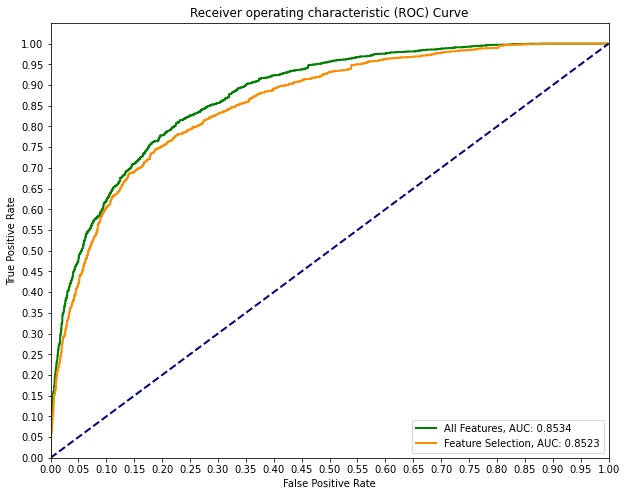

In [73]:
#Visualized ROC Curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr_log, tpr_log, color='g',
         lw=lw, label=f"All Features, AUC: {cross_val_score(logreg, X, y, cv=5, scoring = 'roc_auc').mean():.4f}")
plt.plot(fpr_hicorr, tpr_hicorr, color='darkorange',
         lw=lw, label=f'Feature Selection, AUC: {cross_val_score(logreg_hicorr, X, y, cv=5, scoring = "roc_auc").mean():.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Class Imbalance

Although our data set is large, we still wanted to examine class imbalance to see if bias was affecting our results.  We used SMOTE to oversample the set, creating synthetic data to provide equal quantities of data for both classes of our target variable.  We ultimately did not find that the class imbalance provided insufficient data and were able to proceed with our data set as it was.

In [74]:
y_train.value_counts()

0    17090
1     8276
Name: booking_status, dtype: int64

In [75]:
X1 = df.copy().drop('booking_status', axis = 1)
y1 = df.copy()['booking_status']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.30, random_state=100)
smote = SMOTE(random_state=100)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train1, y_train1)
y_train_resampled.value_counts()

1    17090
0    17090
Name: booking_status, dtype: int64

AUC for 0.005: 0.8504479400485898 

AUC for 0.1: 0.8510355701822386 

AUC for 0.5: 0.8509890577372955 

AUC for 1: 0.8509580876282243 

AUC for 1.5: 0.8509824894774185 

AUC for 2: 0.8510129249606859 

AUC for 10.0: 0.8509164631906315 

AUC for 100.0: 0.8509005389791854 

AUC for 10000.0: 0.8509165395657464 

AUC for 100000.0: 0.8509233751385255 



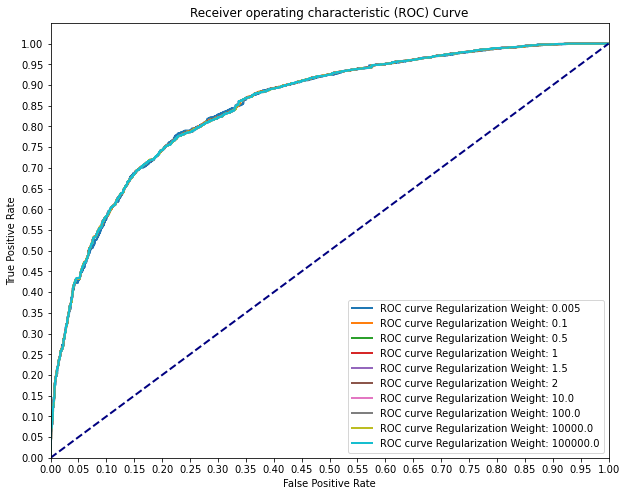

In [76]:
C_param_range = [0.005, 0.1, 0.5, 1, 1.5, 2, 1e1, 1e2, 1e4, 1e5]
names = [0.005, 0.1, 0.5, 1, 1.5, 2, 1e1, 1e2, 1e4, 1e5]

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    logreg_smote = LogisticRegression(fit_intercept=False, C=c, max_iter = 1000, solver = 'liblinear', random_state=100)
    smote_model_log = logreg_smote.fit(X_train_resampled, y_train_resampled)
    y_hat_test = logreg_smote.predict(X_test1)
    y_score = logreg_smote.fit(X_train_resampled, y_train_resampled).decision_function(X_test1)
    fpr, tpr, thresholds = roc_curve(y_test1, y_score)
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)), '\n')
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Highest AUC is 0.85.  Using SMOTE to oversample didn't have any significant effect on our model's performance.  Since our data set was large enough and the proportions of classes in our target variable weren't extreme, we don't need to worry about class imbalance moving forward.

## Decision Tree

Next, we examined a Decision Tree model.  Because Decision Trees have a multitude of hyperparameters to tune so we used for loops to loop through different values and choose the best ones.

In [77]:
#Tested various max depths to find the ideal value
max_depths = list(range(1, 50))
train_results_depth = []
test_results_depth = []

#This for loop loops through possible max depth values of 1 - 50, calculates the AUC of the model given that value, and appends it to a list
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=100)
    dt.fit(X_train, y_train)
    #ROC curve based on train set
    train_pred = dt.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_results_depth.append(roc_auc)
    #ROC curve based on test set
    y_pred = dt.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_results_depth.append(roc_auc)

In [78]:
#Tested various minimum sample splits to find the ideal value
min_samples_splits = np.linspace(0.01, 1.0, 10, endpoint=True)
train_results_splits = []
test_results_splits = []

#This for loop loops through possible minimum sample split values of 0.01 - 10, calculates the AUC of the model given that value, and appends it to a list
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=100)
    dt.fit(X_train, y_train)
    #ROC curve based on train set
    train_pred = dt.predict(X_train)
    fpr, tpr, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_results_splits.append(roc_auc)
    #ROC curve based on test set
    y_pred = dt.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_results_splits.append(roc_auc)

In [79]:
#Tested various minimum sample leafs to find the ideal value
min_samples_leafs = np.linspace(0.01, 0.5, 5, endpoint=True)
train_results_leafs = []
test_results_leafs = []

#This for loop loops through possible minimum sample leaf values of 0.01 - 5, calculates the AUC of the model given that value, and appends it to a list
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=100)
    dt.fit(X_train, y_train)
    #ROC curve based on train set
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results_leafs.append(roc_auc)
    #ROC curve based on test set
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results_leafs.append(roc_auc)

In [80]:
#Tested various maximum features to find the ideal value
max_features = list(range(1, 23))
train_results_features = []
test_results_features = []

#This for loop loops through possible minimum sample leaf values of 1 - 23 (number of features in data set), calculates the AUC of the model given that value, and appends it to a list
for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=100)
    dt.fit(X_train, y_train)
    #ROC curve based on train set
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results_features.append(roc_auc)
    #ROC curve based on test set
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results_features.append(roc_auc)

## Visualizing the results of hyperparameter tuning

Below, we visualized the results of our for loops and their effect on AUC score.  For each, we identified 2 potential values to examine.

Maximum Depth - 7 and 10 both seemed like good values to try.  7 had a lower AUC score, but the results between the test and train sets were closer and less prone to over-fitting.  10 had a higher AUC score, but was potentially over-fitting.

Minimum Sample Leafs - 0.01 (minimum) and 0.255 both looked like good values.  0.01 had the highest AUC score but seemed like it may not be limiting enough to prevent overfitting and also not be too computationally costly.  0.255 was another local maximum to test that didn't have the highest AUC score but also didn't have the limiting factors that 0.01 did.

Minimum Sample Splits - Again, 0.01 showed up as the optimum value alongside 0.12.  Similarly to the Minimum Sample Leafs, we wanted to have two options because 0.01 didn't seem like it would be providing much of any restraints.

Maximum Features - We limited our for loop to 23 maximum.  Although we could have included more after encoding, it became too computationally costly and didn't result in better results.  Instead, we examined 2 local maximums - 4 and 11.

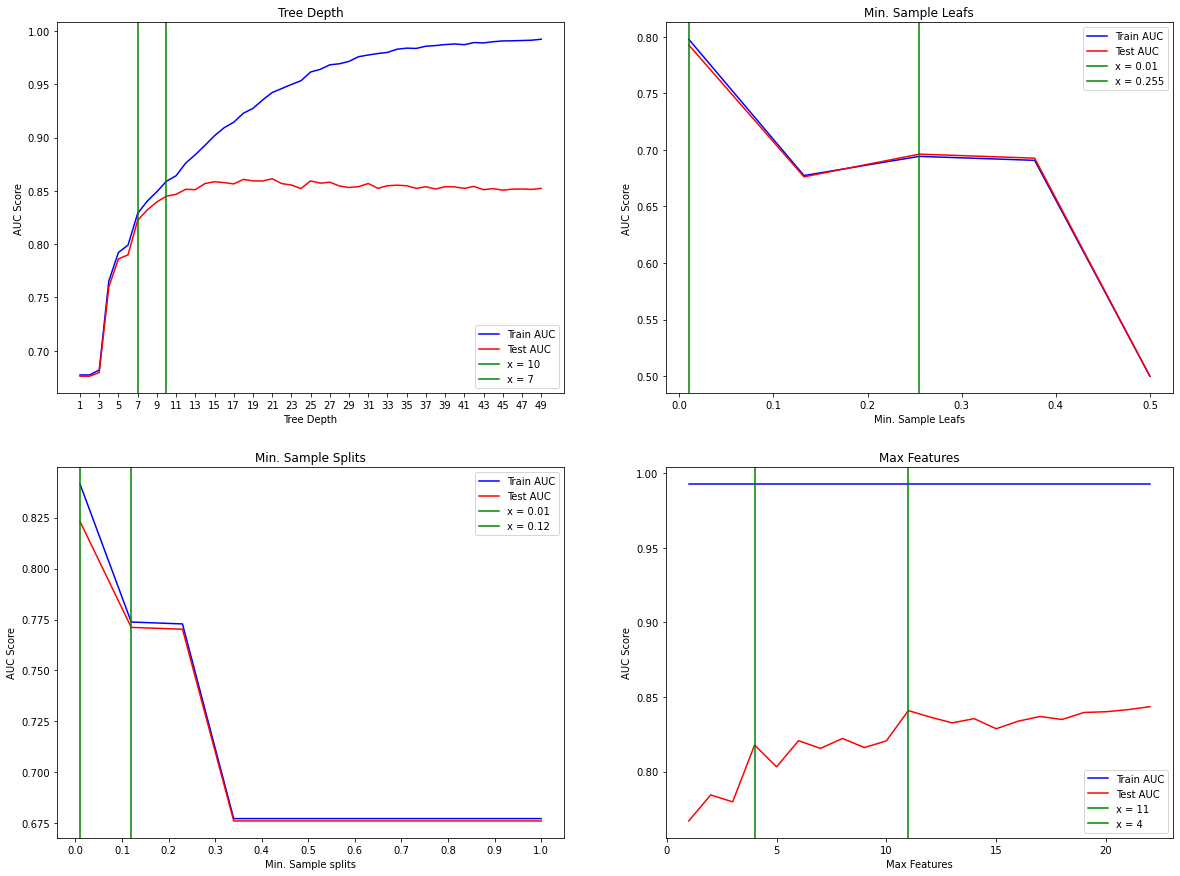

In [81]:
fig, axs = plt.subplots(2, 2, figsize = (20,15))
axs[0,0].plot(max_depths, train_results_depth, 'b', label='Train AUC')
axs[0,0].plot(max_depths, test_results_depth, 'r', label='Test AUC')
axs[0,0].axvline(x=10, color = 'g', label = 'x = 10')
axs[0,0].axvline(x=7, color = 'g', label = 'x = 7')
axs[0,0].set_xticks(list(range(1, 50, 2)))
axs[0,0].set_title('Tree Depth')
axs[0,0].set_ylabel('AUC Score')
axs[0,0].set_xlabel('Tree Depth')
axs[0,0].legend()

axs[1,0].plot(min_samples_splits, train_results_splits, 'b', label='Train AUC')
axs[1,0].plot(min_samples_splits, test_results_splits, 'r', label='Test AUC')
axs[1,0].axvline(x=0.01, color = 'g', label = 'x = 0.01')
axs[1,0].axvline(x=0.12, color = 'g', label = 'x = 0.12')
axs[1,0].set_xticks(list(np.arange(0, 1.1, 0.1)))
axs[1,0].set_title('Min. Sample Splits')
axs[1,0].set_ylabel('AUC Score')
axs[1,0].set_xlabel('Min. Sample splits')
axs[1,0].legend()

axs[0,1].plot(min_samples_leafs, train_results_leafs, 'b', label='Train AUC')
axs[0,1].plot(min_samples_leafs, test_results_leafs, 'r', label='Test AUC')
axs[0,1].axvline(x=0.01, color = 'g', label = 'x = 0.01')
axs[0,1].axvline(x=0.255, color = 'g', label = 'x = 0.255')
axs[0,1].set_title('Min. Sample Leafs')
axs[0,1].set_ylabel('AUC Score')
axs[0,1].set_xlabel('Min. Sample Leafs')
axs[0,1].legend();

axs[1,1].plot(max_features, train_results_features, 'b', label='Train AUC')
axs[1,1].plot(max_features, test_results_features, 'r', label='Test AUC')
axs[1,1].axvline(x=11, color = 'g', label = 'x = 11')
axs[1,1].axvline(x=4, color = 'g', label = 'x = 4')
axs[1,1].set_title('Max Features')
axs[1,1].set_ylabel('AUC Score')
axs[1,1].set_xlabel('Max Features')
axs[1,1].legend();

## Final Results - Decision Tree

We ran our Decision Tree model with the tuned hyperparameters both with the X_train and X_test sets and the X_train_hicorr and X_test_hicorr sets.

With all features included, our Decision Tree model scored 0.8007 for AUC.  Not bad, but not better than our Logistic Regression model.  This time, our feature-selected set performed better with an AUC score of 0.8317, but again, not better than our Logistic Regression model.

Decision Tree with All Features
AUC: 0.8007
Train Recall: 0.6091
Test Recall: 0.5966
Train Precision: 0.6743
Test Precision: 0.6796
Train Accuracy: 0.7765
Test Accuracy: 0.7732
Train F1 Score: 0.6400
Test F1 Score: 0.6354


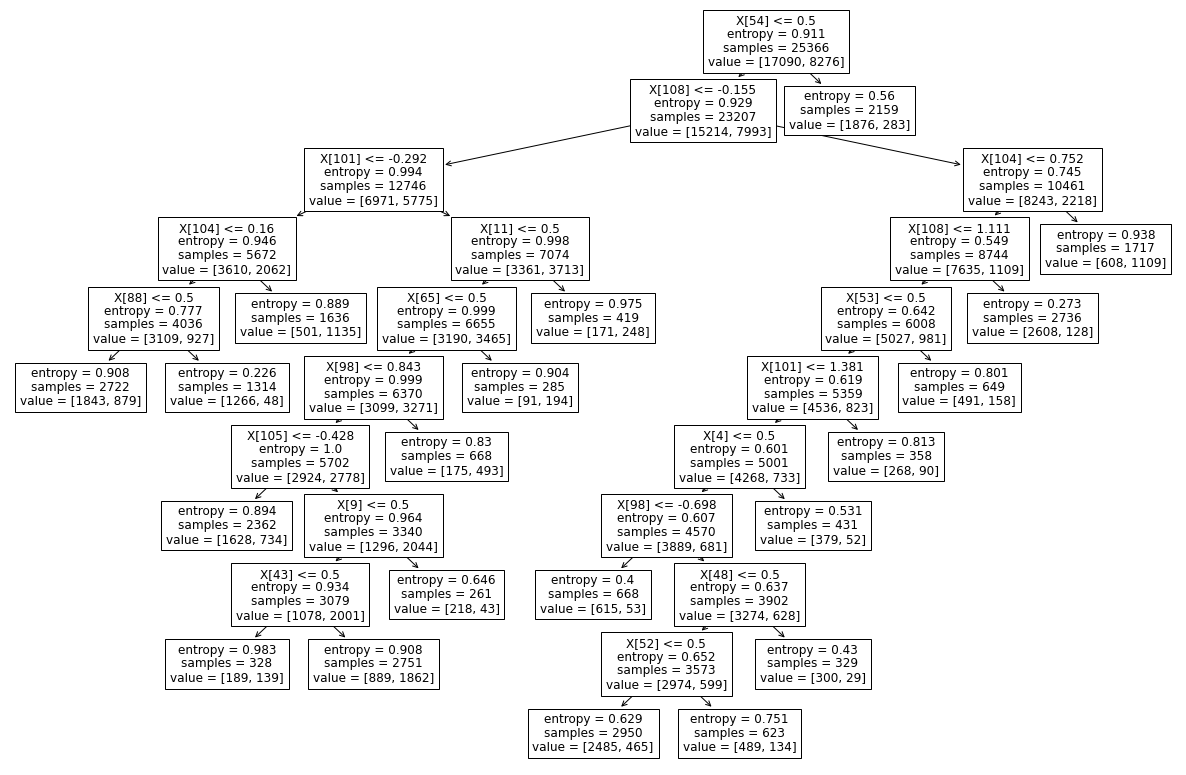

In [82]:
#Used best hyperparameter values to maximize AUC score
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=11,
                           max_depth=10,
                           min_samples_split=0.12,
                           min_samples_leaf=0.01, 
                           random_state=100)
dt.fit(X_train, y_train)
test_pred_dt = dt.predict(X_test)

#Calculated AUC score
#fpr_dt, tpr_dt, thresholds = roc_curve(y_test, test_pred_dt)
#roc_auc_dt = auc(fpr_dt, tpr_dt)
y_hat_train_dt = dt.predict(X_train)
y_hat_test_dt = dt.predict(X_test)
print("Decision Tree with All Features")
print(f"AUC: {cross_val_score(dt, X_test, y_test, cv=5, scoring = 'roc_auc').mean():.4f}")
print(f"Train Recall: {recall_score(y_train, y_hat_train_dt):.4f}")
print(f"Test Recall: {recall_score(y_test, y_hat_test_dt):.4f}")
print(f"Train Precision: {precision_score(y_train, y_hat_train_dt):.4f}")
print(f"Test Precision: {precision_score(y_test, y_hat_test_dt):.4f}")
print(f"Train Accuracy: {accuracy_score(y_train, y_hat_train_dt):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_hat_test_dt):.4f}")
print(f"Train F1 Score: {f1_score(y_train, y_hat_train_dt):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_hat_test_dt):.4f}")

#Visualized decision tree
plt.figure(figsize= (21, 14))
plot_tree(dt)
plt.show()

Decision Tree with Feature Selection
AUC: 0.8317
Train Recall: 0.5724
Test Recall: 0.5644
Train Precision: 0.6576
Test Precision: 0.6652
Train Accuracy: 0.7633
Test Accuracy: 0.7616
Train F1 Score: 0.6121
Test F1 Score: 0.6107


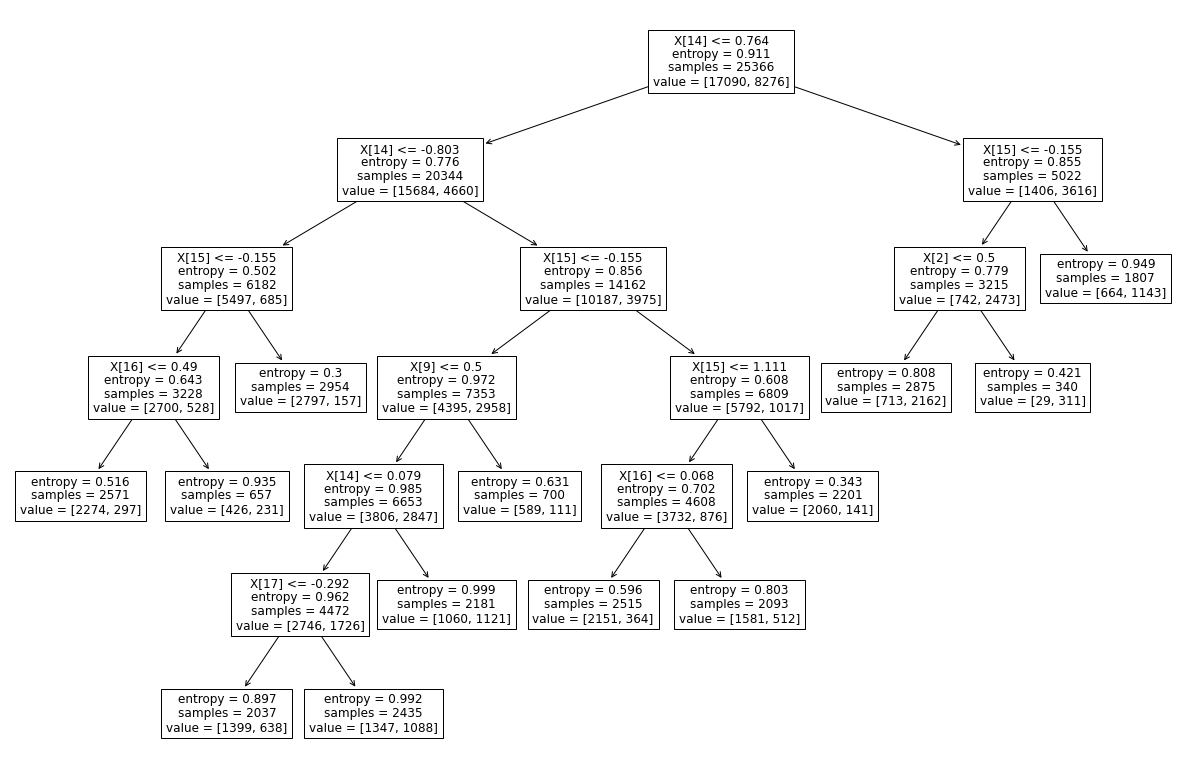

In [83]:
#Used best hyperparameter values to maximize AUC score
dt_hicorr = DecisionTreeClassifier(criterion='entropy',
                           max_features=11,
                           max_depth=10,
                           min_samples_split=0.12,
                           min_samples_leaf=0.01, 
                           random_state=100)
dt_hicorr.fit(X_train_hicorr, y_train)
test_pred_dt_hicorr = dt_hicorr.predict(X_test_hicorr)

#Calculated AUC score
fpr_dt_hicorr, tpr_dt_hicorr, thresholds = roc_curve(y_test, test_pred_dt_hicorr)
roc_auc_dt_hicorr = auc(fpr_dt_hicorr, tpr_dt_hicorr)
train_pred_dt_hicorr = dt_hicorr.predict(X_train_hicorr)

print("Decision Tree with Feature Selection")
print(f"AUC: {cross_val_score(dt_hicorr, X_test_hicorr, y_test, cv=5, scoring = 'roc_auc').mean():.4f}")
print(f"Train Recall: {recall_score(y_train, train_pred_dt_hicorr):.4f}")
print(f"Test Recall: {recall_score(y_test, test_pred_dt_hicorr):.4f}")
print(f"Train Precision: {precision_score(y_train, train_pred_dt_hicorr):.4f}")
print(f"Test Precision: {precision_score(y_test, test_pred_dt_hicorr):.4f}")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred_dt_hicorr):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_dt_hicorr):.4f}")
print(f"Train F1 Score: {f1_score(y_train, train_pred_dt_hicorr):.4f}")
print(f"Test F1 Score: {f1_score(y_test,test_pred_dt_hicorr):.4f}")

#Visualized decision tree
plt.figure(figsize= (21, 14))
plot_tree(dt_hicorr)
plt.show()

## Random Forest Classifier

Finally, we used Random Forest Classifier as our final classification model.  Because our data set was large and our emphasis is on future unseen data prediction, we wanted to guard against over-fitting and the potential of our model split being an outlier.  Random Forest Classifier helped us be more confident that our results would be able to predict the results of unseen data.

Again, we ran the same methods for Random Forest Classifier that we did for Decision Trees to tune our hyperparameters.

In [84]:
#Tested various max depths to find the ideal value
max_depths_rf = list(range(1, 30))
train_results_rf_depth = []
test_results_rf_depth = []

#This for loop loops through possible max depth values of 1 - 50, calculates the AUC of the model given that value, and appends it to a list
for max_depth in max_depths_rf:
    rf = RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_depth = max_depth, random_state=100)
    rf.fit(X_train, y_train)
    #ROC curve based on train set
    train_pred_rf = rf.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred_rf)
    roc_auc = auc(fpr, tpr)
    train_results_rf_depth.append(roc_auc)
    #ROC curve based on test set
    test_pred_rf = rf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_rf)
    roc_auc = auc(fpr, tpr)
    test_results_rf_depth.append(roc_auc)

In [85]:
#Tested various minimum sample splits to find the ideal value
min_samples_splits_rf = np.linspace(0.01, 1.0, 10, endpoint=True)
train_results_rf_splits = []
test_results_rf_splits = []

#This for loop loops through possible minimum sample split values of 0.01 - 10, calculates the AUC of the model given that value, and appends it to a list
for min_samples_split in min_samples_splits_rf:
    rf = RandomForestClassifier(n_estimators=100, criterion = 'entropy', min_samples_split = min_samples_split, random_state=100)
    rf.fit(X_train, y_train)
    #ROC curve based on train set
    train_pred_rf = rf.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred_rf)
    roc_auc = auc(fpr, tpr)
    train_results_rf_splits.append(roc_auc)
    #ROC curve based on test set
    test_pred_rf = rf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_rf)
    roc_auc = auc(fpr, tpr)
    test_results_rf_splits.append(roc_auc)

In [86]:
#Tested various minimum sample leafs to find the ideal value
min_samples_leafs_rf = np.linspace(0.01, 0.5, 5, endpoint=True)
train_results_rf_leafs = []
test_results_rf_leafs = []

#This for loop loops through possible minimum sample leaf values of 0.01 - 5, calculates the AUC of the model given that value, and appends it to a list
for min_samples_leaf in min_samples_leafs_rf:
    rf = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=100)
    rf.fit(X_train, y_train)
    #ROC curve based on train set
    train_pred_rf = rf.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred_rf)
    roc_auc = auc(fpr, tpr)
    train_results_rf_leafs.append(roc_auc)
    #ROC curve based on test set
    test_pred_rf = rf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_rf)
    roc_auc = auc(fpr, tpr)
    test_results_rf_leafs.append(roc_auc)

In [87]:
#Tested various maximum features to find the ideal value
max_features_rf = list(range(1, 23))
train_results_rf_features = []
test_results_rf_features = []

#This for loop loops through possible minimum sample leaf values of 1 - 23 (number of features in data set), calculates the AUC of the model given that value, and appends it to a list
for max_feature in max_features_rf:
    rf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features=max_feature, random_state=100)
    rf.fit(X_train, y_train)
    #ROC curve based on train set
    train_pred_rf = rf.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred_rf)
    roc_auc = auc(fpr, tpr)
    train_results_rf_features.append(roc_auc)
    #ROC curve based on test set
    test_pred_rf = rf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_rf)
    roc_auc = auc(fpr, tpr)
    test_results_rf_features.append(roc_auc)

## Visualizing the results of hyperparameter tuning

Again, we visualized the effects of various hyparameter values on the AUC score.

Max Depth - 13 and 17 were both potential values for us to examine.  13 had the lower AUC score, and 17 had a higher AUC score but beyond that, we were seeing higher potential to over-fit without any significant gain in AUC score.

Minimum Sample Leafs and Minimum Sample Splits - Both of these hyperparameters showed a very steep decline in AUC score with any increase in value.  We kept both hyperparameters to 0.01 in our model.

Max Features - Again, we wanted to keep our max features value to a reasonable number.  14 and 19 represented 2 local maximums for us to examine.

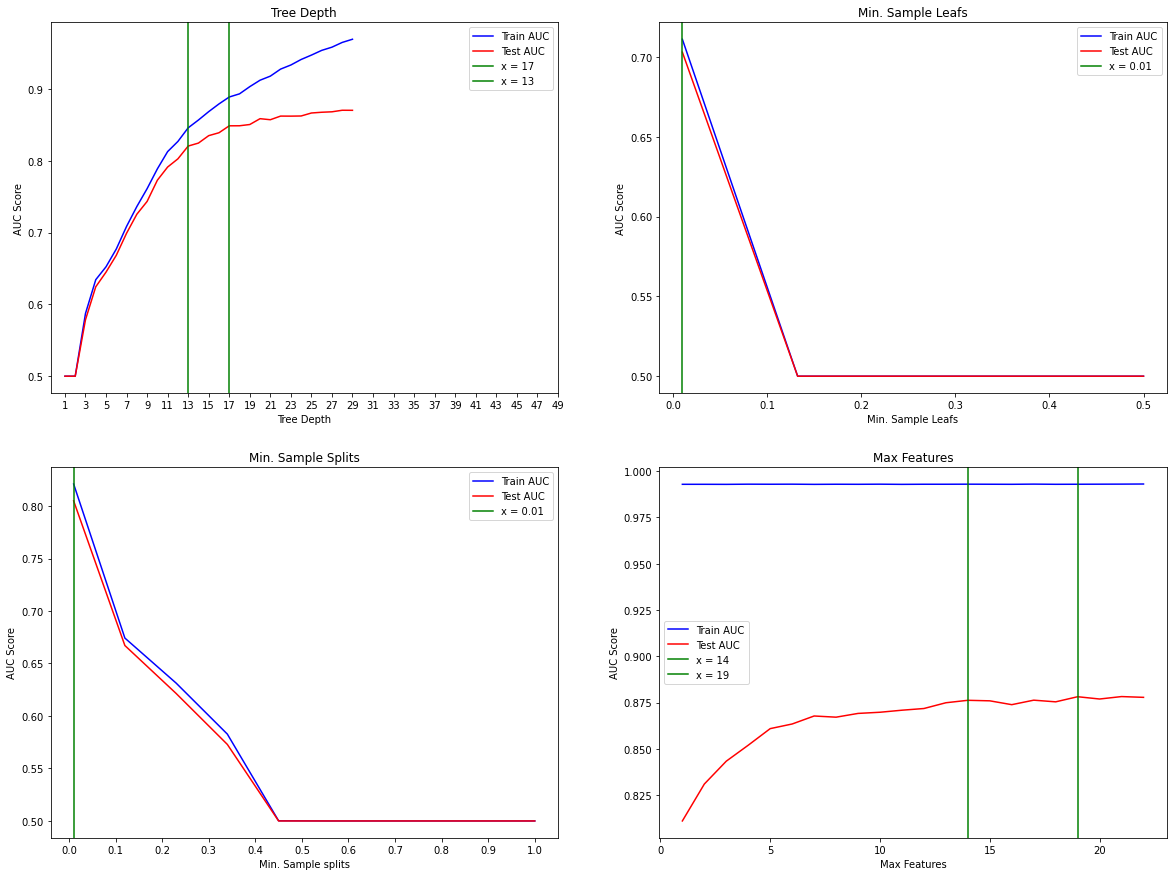

In [88]:
#Visualized effects of various hyperparameter values on AUC for RandomForestClassifier model
fig, axs = plt.subplots(2, 2, figsize = (20,15))
axs[0,0].plot(max_depths_rf, train_results_rf_depth, 'b', label='Train AUC')
axs[0,0].plot(max_depths_rf, test_results_rf_depth, 'r', label='Test AUC')
axs[0,0].axvline(x=17, color = 'g', label = 'x = 17')
axs[0,0].axvline(x=13, color = 'g', label = 'x = 13')
axs[0,0].set_xticks(list(range(1, 50, 2)))
axs[0,0].set_title('Tree Depth')
axs[0,0].set_ylabel('AUC Score')
axs[0,0].set_xlabel('Tree Depth')
axs[0,0].legend()

axs[1,0].plot(min_samples_splits_rf, train_results_rf_splits, 'b', label='Train AUC')
axs[1,0].plot(min_samples_splits_rf, test_results_rf_splits, 'r', label='Test AUC')
axs[1,0].axvline(x=0.01, color = 'g', label = 'x = 0.01')
axs[1,0].set_xticks(list(np.arange(0, 1.1, 0.1)))
axs[1,0].set_title('Min. Sample Splits')
axs[1,0].set_ylabel('AUC Score')
axs[1,0].set_xlabel('Min. Sample splits')
axs[1,0].legend()

axs[0,1].plot(min_samples_leafs_rf, train_results_rf_leafs, 'b', label='Train AUC')
axs[0,1].plot(min_samples_leafs_rf, test_results_rf_leafs, 'r', label='Test AUC')
axs[0,1].axvline(x=0.01, color = 'g', label = 'x = 0.01')
axs[0,1].set_title('Min. Sample Leafs')
axs[0,1].set_ylabel('AUC Score')
axs[0,1].set_xlabel('Min. Sample Leafs')
axs[0,1].legend();

axs[1,1].plot(max_features_rf, train_results_rf_features, 'b', label='Train AUC')
axs[1,1].plot(max_features_rf, test_results_rf_features, 'r', label='Test AUC')
axs[1,1].axvline(x=14, color = 'g', label = 'x = 14')
axs[1,1].axvline(x=19, color = 'g', label = 'x = 19')
axs[1,1].set_title('Max Features')
axs[1,1].set_ylabel('AUC Score')
axs[1,1].set_xlabel('Max Features')
axs[1,1].legend();

## Final Results - Random Forest Classifier

We ran our Random Forest Classifier under 4 different conditions:

1. All features included and no hyperparameter tuning - This model produced a very high AUC score, 0.9359.  However, we noticed that the difference in scores between the train and test sets were very high and the scores for the train set were 0.98-0.99, clearly indicating over-fitting.
2. All features included and tuned hyperparameters - This model produced an AUC score higher than all of our Logistic Regression and Decision Tree models with 0.8807.  This model also does not run into issues with over-fitting.  However, it was not our best iteration of Random Forest Classifier.
3. Feature selection in place and no hyperparameter tuning - Again, we saw a very high AUC score of 0.9256.  However, again, we saw very clear signs of over-fitting and had to reject the model.
4. Feature selection and tuned hyperparameters - Finally, this model produced the highest AUC score without over-fitting, with 0.8850.  This is our final model and the one that we are recommending Flatiron Hotels to use moving forward.

In [89]:
#Calculated AUC for RandomForestClassifier model with default hyperparameters
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=100)
rf_classifier.fit(X_train, y_train)
y_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]
train_pred_rf = rf_classifier.predict(X_train)
test_pred_rf = rf_classifier.predict(X_test)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("Random Forest Classifier with All Features and No Hyperparameter Tuning")
print(f"AUC: {cross_val_score(rf_classifier, X_test, y_test, cv=5, scoring = 'roc_auc').mean():.4f}")
print(f"Train Recall: {recall_score(y_train, train_pred_rf):.4f}")
print(f"Test Recall: {recall_score(y_test, test_pred_rf):.4f}")
print(f"Train Precision: {precision_score(y_train, train_pred_rf):.4f}")
print(f"Test Precision: {precision_score(y_test, test_pred_rf):.4f}")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred_rf):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_rf):.4f}")
print(f"Train F1 Score: {f1_score(y_train, train_pred_rf):.4f}")
print(f"Test F1 Score: {f1_score(y_test, test_pred_rf):.4f}")

Random Forest Classifier with All Features and No Hyperparameter Tuning
AUC: 0.9359
Train Recall: 0.9879
Test Recall: 0.7873
Train Precision: 0.9960
Test Precision: 0.8907
Train Accuracy: 0.9948
Test Accuracy: 0.8975
Train F1 Score: 0.9919
Test F1 Score: 0.8358


In [90]:
#Calculated AUC for RandomForestClassifier model with calculated optimum hyperparameters
rf_classifier_params = RandomForestClassifier(n_estimators=100, max_features=19, max_depth=13, min_samples_split=0.01, min_samples_leaf=0.01, criterion = 'entropy', random_state=100)
rf_classifier_params.fit(X_train, y_train)
y_proba_params = rf_classifier_params.predict_proba(X_test)[:, 1]
roc_auc_params = roc_auc_score(y_test, y_proba_params)
train_pred_rf_params = rf_classifier_params.predict(X_train)
test_pred_rf_params = rf_classifier_params.predict(X_test)
print("Random Forest Classifier with All Features and Tuned Hyperparameters")
print(f"AUC: {cross_val_score(rf_classifier_params, X_test, y_test, cv=5, scoring = 'roc_auc').mean():.4f}")
print(f"Train Recall: {recall_score(y_train, train_pred_rf_params):.4f}")
print(f"Test Recall: {recall_score(y_test, test_pred_rf_params):.4f}")
print(f"Train Precision: {precision_score(y_train, train_pred_rf_params):.4f}")
print(f"Test Precision: {precision_score(y_test, test_pred_rf_params):.4f}")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred_rf_params):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_rf_params):.4f}")
print(f"Train F1 Score: {f1_score(y_train, train_pred_rf_params):.4f}")
print(f"Test F1 Score: {f1_score(y_test, test_pred_rf_params):.4f}")

Random Forest Classifier with All Features and Tuned Hyperparameters
AUC: 0.8807
Train Recall: 0.5906
Test Recall: 0.5836
Train Precision: 0.8299
Test Precision: 0.8418
Train Accuracy: 0.8269
Test Accuracy: 0.8257
Train F1 Score: 0.6901
Test F1 Score: 0.6893


In [91]:
#Calculated AUC for RandomForestClassifier model with only highly correlated columns
rf_classifier_hicorr = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=100)
rf_classifier_hicorr.fit(X_train_hicorr, y_train)
y_proba_rf_hicorr = rf_classifier_hicorr.predict_proba(X_test_hicorr)[:, 1]
roc_auc_rf_hicorr = roc_auc_score(y_test, y_proba_rf_hicorr)
train_pred_rf_hicorr = rf_classifier_hicorr.predict(X_train_hicorr)
test_pred_rf_hicorr = rf_classifier_hicorr.predict(X_test_hicorr)
print("Random Forest Classifier with Feature Selection and No Hyperparamater Tuning")
print(f"AUC: {cross_val_score(rf_classifier_hicorr, X_test_hicorr, y_test, cv=5, scoring = 'roc_auc').mean():.4f}")
print(f"Train Recall: {recall_score(y_train, train_pred_rf_hicorr):.4f}")
print(f"Test Recall: {recall_score(y_test, test_pred_rf_hicorr):.4f}")
print(f"Train Precision: {precision_score(y_train, train_pred_rf_hicorr):.4f}")
print(f"Test Precision: {precision_score(y_test, test_pred_rf_hicorr):.4f}")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred_rf_hicorr):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_rf_hicorr):.4f}")
print(f"Train F1 Score: {f1_score(y_train, train_pred_rf_hicorr):.4f}")
print(f"Test F1 Score: {f1_score(y_test, test_pred_rf_hicorr):.4f}")

Random Forest Classifier with Feature Selection and No Hyperparamater Tuning
AUC: 0.9256
Train Recall: 0.9848
Test Recall: 0.7868
Train Precision: 0.9938
Test Precision: 0.8622
Train Accuracy: 0.9930
Test Accuracy: 0.8877
Train F1 Score: 0.9893
Test F1 Score: 0.8228


In [92]:
#Calculated AUC for RandomForestClassifier model with only highly correlated columns and tuned hyperparameters
rf_classifier_hicorr_params = RandomForestClassifier(n_estimators=100, max_features=19, max_depth=13, min_samples_split=0.01, min_samples_leaf=0.01, criterion = 'entropy', random_state=100)
rf_classifier_hicorr_params.fit(X_train_hicorr, y_train)
y_proba_rf_hicorr_params = rf_classifier_hicorr_params.predict_proba(X_test_hicorr)[:, 1]
roc_auc_rf_hicorr_params = roc_auc_score(y_test, y_proba_rf_hicorr_params)
train_pred_rf_hicorr_params = rf_classifier_hicorr_params.predict(X_train_hicorr)
test_pred_rf_hicorr_params = rf_classifier_hicorr_params.predict(X_test_hicorr)
print("Random Forest Classifier with Feature Selection and Tuned Hyperparameters")
print(f"AUC: {cross_val_score(rf_classifier_hicorr_params, X_test_hicorr, y_test, cv=5, scoring = 'roc_auc').mean():.4f}")
print(f"Train Recall: {recall_score(y_train, train_pred_rf_hicorr_params):.4f}")
print(f"Test Recall: {recall_score(y_test, test_pred_rf_hicorr_params):.4f}")
print(f"Train Precision: {precision_score(y_train, train_pred_rf_hicorr_params):.4f}")
print(f"Test Precision: {precision_score(y_test, test_pred_rf_hicorr_params):.4f}")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred_rf_hicorr_params):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_rf_hicorr_params):.4f}")
print(f"Train F1 Score: {f1_score(y_train, train_pred_rf_hicorr_params):.4f}")
print(f"Test F1 Score: {f1_score(y_test, test_pred_rf_hicorr_params):.4f}")

Random Forest Classifier with Feature Selection and Tuned Hyperparameters
AUC: 0.8850
Train Recall: 0.6340
Test Recall: 0.6272
Train Precision: 0.8097
Test Precision: 0.8203
Train Accuracy: 0.8320
Test Accuracy: 0.8309
Train F1 Score: 0.7112
Test F1 Score: 0.7108


## Conclusion

Ultimately, we tested the following models:

1. Logistic Regression with all features
2. Logistic Regression with feature selection
3. Decision Tree with all features and tuned hyperparameters
4. Decision Tree with feature selection and tuned hyperparameters
5. Random Forest Classifier with all features and no hyperparameter tuning
6. Random Forest Classifier with feature selection and no hyperparameter tuning
7. Random Forest Classifier with all features and tuned hyperparameters
8. <span style='color:green'>Random Forest Classifier with feature selection and tuned hyperparameters.</span>

Our final model, Random Forest Classifier with feature selection and tuned hyperparameters, produced the best results without over-fitting our train data.  Our AUC of 0.8850 shows a solid confidence in our classification.  We used this metric because we wanted to measure overall performance to measure both false positives and false negatives, with a slight bias towards the positive class to be safe.

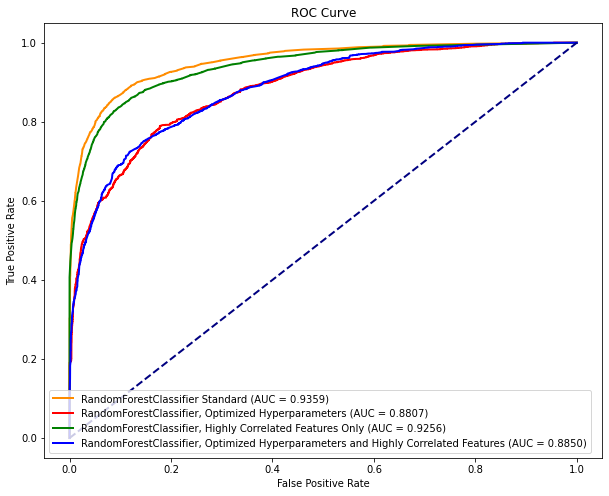

In [93]:
#Visualized ROC curve for RandomForestClassifier model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
fpr_params, tpr_params, thresholds_params = roc_curve(y_test, y_proba_params)
fpr_hicorr, tpr_hicorr, thresholds_hicorr = roc_curve(y_test, y_proba_rf_hicorr)
fpr_hicorr_params, tpr_hicorr_params, thresholds_hicorr_params = roc_curve(y_test, y_proba_rf_hicorr_params)
plt.figure(figsize=(10,8))
plt.plot(fpr_rf, tpr_rf, label=f'RandomForestClassifier Standard (AUC = {cross_val_score(rf_classifier, X_test, y_test, cv=5, scoring = "roc_auc").mean():.4f})', color='darkorange',
         lw=lw)
plt.plot(fpr_params, tpr_params, label=f'RandomForestClassifier, Optimized Hyperparameters (AUC = {cross_val_score(rf_classifier_params, X_test, y_test, cv=5, scoring = "roc_auc").mean():.4f})', color = 'r', lw=lw)
plt.plot(fpr_hicorr, tpr_hicorr, label=f'RandomForestClassifier, Highly Correlated Features Only (AUC = {cross_val_score(rf_classifier_hicorr, X_test_hicorr, y_test, cv=5, scoring = "roc_auc").mean():.4f})', color = 'g', lw=lw)
plt.plot(fpr_hicorr_params, tpr_hicorr_params, label=f'RandomForestClassifier, Optimized Hyperparameters and Highly Correlated Features (AUC = {cross_val_score(rf_classifier_hicorr_params, X_test_hicorr, y_test, cv=5, scoring="roc_auc").mean():.4f})', color = 'b', lw=lw)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw = lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()